In [1]:
# Cálcula el porcentaje de error entre dos series de máximos anuales.

import itertools
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [2]:
# Cantidad de celdas a eliminar del borde.
k = 1

# Archivos a evaluar.
eval = [ [0, 2], [0, 7], [4, 5], [5, 6], [8, 6], [9, 10], [11, 12], [13, 14] ]
n = 7
i = eval[n][0]
j = eval[n][1]
var = "wenzel"
#var = "medido"

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_era5_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "prec_mroc_hist_hist_days", "prec_mroc_h20a_hist",
    "prec_mroc_h20a_hist_coarsen_5", "prec_mroc_2040_2040_coarsen_5",
    "WRF_regrid_CHIRPS_days_qmap", "WRF_2040_regrid_CHIRPS_days_qmap",
    "WRF_regrid_ERA5_1985_2014_qmap", "WRF_regrid_ERA5_2040_2059_qmap" ]

fname = f"{name[i]}_{name[j]}"
temp_d = "../../../temp/cc_idt/"
dir = f"{temp_d}comp/{fname}/"

# Si no existe la carpeta, la crea.
if not os.path.exists(f"{temp_d}comp/"): os.mkdir(f"{temp_d}comp/")
if not os.path.exists(dir): os.mkdir(dir)

if var == "wenzel":
    path_orig   = f"{temp_d}SAM/{name[i]}/{name[i]}_idf_valores.nc" 
    path_comp   = f"{temp_d}SAM/{name[j]}/{name[j]}_idf_valores.nc" 
if var == "medido":
    path_orig   = f"{temp_d}SAM/{name[i]}/{name[i]}_tretorno.nc" 
    path_comp   = f"{temp_d}SAM/{name[j]}/{name[j]}_tretorno.nc" 
path_orig_s = f"{temp_d}SAM/{name[i]}/{name[i]}_stats.nc" 
path_comp_s = f"{temp_d}SAM/{name[j]}/{name[j]}_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

# Estadísticas de los valores originales.
ds_orig.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,42750.000000
mean,10.631054
std,8.899470
min,1.958412
25%,5.641302
50%,8.133329
75%,12.139105
max,139.340120


In [3]:
ds_orig

<xarray.Dataset> Size: 343kB
Dimensions:         (LONGITUD: 25, LATITUD: 19, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 200B -100.1 -100.0 -99.9 ... -97.8 -97.7
  * LATITUD         (LATITUD) float64 152B 18.5 18.6 18.7 ... 20.1 20.2 20.3
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 342kB ...

In [4]:
ds_comp

<xarray.Dataset> Size: 343kB
Dimensions:         (LONGITUD: 25, LATITUD: 19, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 200B -100.1 -100.0 -99.9 ... -97.8 -97.7
  * LATITUD         (LATITUD) float64 152B 18.5 18.6 18.7 ... 20.1 20.2 20.3
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 342kB ...

In [5]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf(dir + fname + "_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre WRF_regrid_ERA5_1985_2014_qmap y WRF_regrid_ERA5_2040_2059_qmap
count: 5700.00
mean: 0.06
std: 0.24
min: -0.57
25%: -0.09
50%: 0.06
75%: 0.20
max: 1.20


In [6]:
# Error en el total de precipitación.
prec_e = ( comp_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum()
    / orig_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum() - 1 )

prec_e.describe()

,PRECIPITACION
count,475.000000
mean,0.071476
std,0.137086
min,-0.256387
25%,-0.006624
50%,0.050921
75%,0.107325
max,0.649992


In [7]:
# Error total.
if var == "medido":
    ds_comp = ds_comp.drop_vars( ["AÑO", "PROBABILIDAD"] )
    ds_orig = ds_orig.drop_vars( ["AÑO", "PROBABILIDAD"] )
error = ( ( ds_comp - ds_orig )
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
#error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
#    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ) )
#    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf(dir + fname + ".nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre WRF_regrid_ERA5_1985_2014_qmap y WRF_regrid_ERA5_2040_2059_qmap
count: 42750.00
mean: 0.18
std: 0.34
min: -0.81
25%: -0.01
50%: 0.19
75%: 0.37
max: 2.90


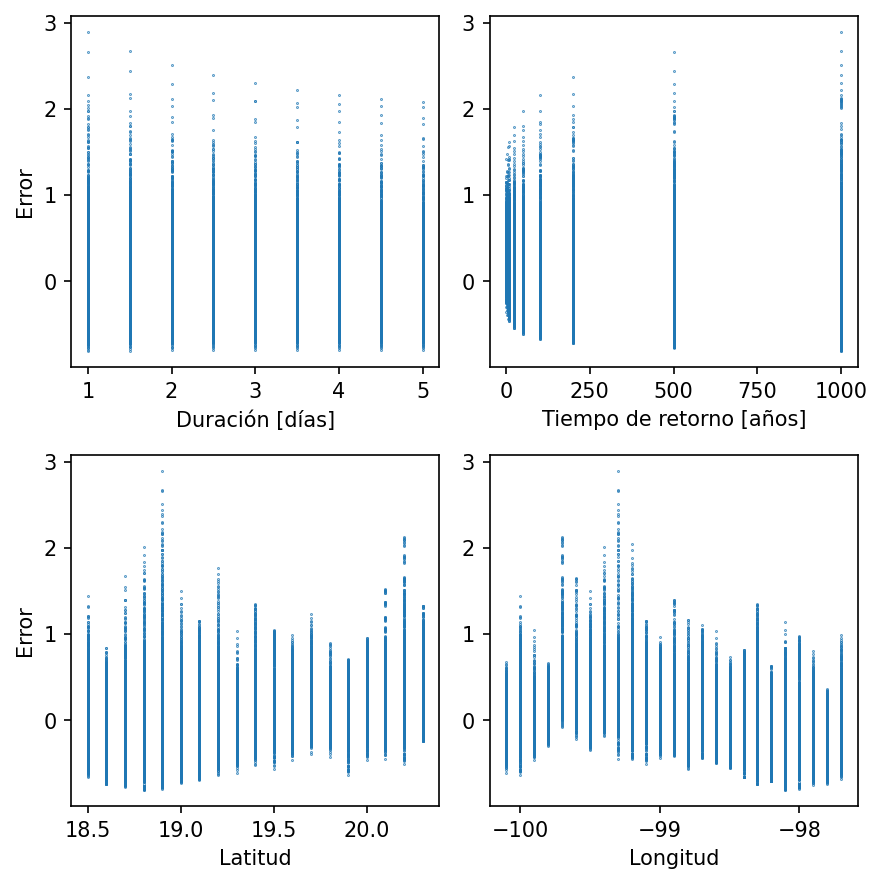

In [8]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

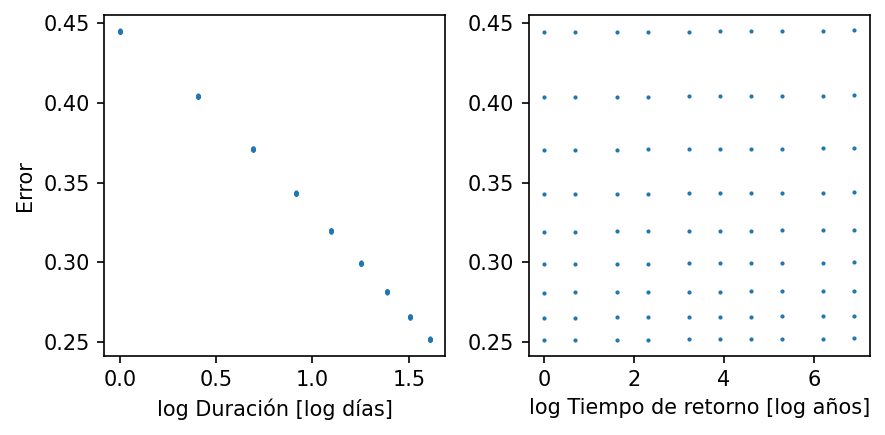

In [9]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 5
N = 5
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
#ax[0].scatter( f_xs.reset_index()["DURACION"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
#ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( np.log( df_xs.reset_index()["TIEMPO_RETORNO"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
#ax[0].set_xlabel(f"Duración [días]")
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
#ax[1].set_xlabel(f"Tiempo de retorno [años]")
ax[1].set_xlabel(f"log Tiempo de retorno [log años]")

fig.tight_layout()
plt.show()

In [10]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log(  df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.log(  df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              "T_1",
                              #"T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.472e+04
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          8.29e-111
Time:                        20:36:14   Log-Likelihood:                 385.16
No. Observations:                  90   AIC:                            -764.3
Df Residuals:                      87   BIC:                            -756.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4508      0.001    465.267      0.000       0.449       0.453
D_1           -0.1219      0.001   -171.561      0.000      -0.123      -0.120
T_1            0.0002      0.000      1.000      0.320      -0.000       0.000
==============================================================================
Omnibus:                       13.285   Durbin-Watson:                   0.087
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.869
Skew:                          -0.485   Prob(JB):                       0.0322
Kurtosis:                       2.055   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Intentamos obtener un valor para todo el dominio.

# Error normalizado
#error_n = ( error / error.sel(DURACION = 1, TIEMPO_RETORNO = 5 )
#    ).to_dataframe().droplevel(level = (0, 1) ).reset_index()
# Error sin normalizar.
error_n = df_e.copy().reset_index()

# Regresión múltiple logarítmica.
X = sm.add_constant( np.log( error_n[["DURACION", "TIEMPO_RETORNO"]] ) )
Y = error_n[["P_ERROR"]]
model = sm.OLS(Y,X)
results = model.fit()
# Ajuste de la regresión.
results.rsquared_adj

0.020041975577247295

In [12]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR",
        "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR",
        #"C_TRET",
        "P_CONST",
        "P_LOG_DUR",
        "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #"P_DUR",
        #"P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            #"DURACION",
            #"TIEMPO_RETORNO",
            "LOG_DURACION",
            "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

for c in df_s.columns:
    df_s[c] = df_s[c].astype(float)

# Guardamos el archivo.
df_s.to_xarray().to_netcdf(dir + fname + "_reglin.nc")

# Estadísticas de los valores de la regresión.
df_s.describe()

,CONST,C_LOG_DUR,C_LOG_TRET,P_CONST,P_LOG_DUR,P_LOG_TRET,ADJ_R_SQUARED,P_F_STAT,P_JB,COND_NO,P_BP
count,475.000000,475.000000,475.000000,4.750000e+02,4.750000e+02,4.750000e+02,475.000000,4.750000e+02,4.750000e+02,475.000000,4.750000e+02
mean,0.269066,-0.008665,-0.021791,8.917792e-03,2.620787e-02,1.099719e-02,0.957413,5.672244e-04,1.139349e-01,13.458762,2.019909e-01
std,0.238585,0.087815,0.056928,6.878801e-02,1.206836e-01,7.850884e-02,0.099661,1.080929e-02,1.709885e-01,0.000000,2.385825e-01
min,-0.327352,-0.418480,-0.131557,2.722013e-220,6.022182e-144,3.324815e-136,0.010722,6.932954e-144,6.032012e-16,13.458762,1.663114e-13
25%,0.108216,-0.052582,-0.057871,1.546403e-107,4.854756e-60,9.104913e-93,0.968451,1.416658e-96,1.249680e-02,13.458762,3.412476e-03
50%,0.249893,0.002075,-0.024931,2.748748e-77,3.279896e-34,2.847754e-78,0.986675,9.859879e-83,2.449830e-02,13.458762,1.015312e-01
75%,0.402241,0.052481,0.008281,5.525961e-42,2.671074e-13,5.789750e-62,0.993596,1.910536e-66,1.292028e-01,13.458762,3.264935e-01
max,1.423302,0.201184,0.225587,8.594349e-01,9.784429e-01,9.896354e-01,0.999477,2.327939e-01,8.297412e-01,13.458762,9.927844e-01


In [13]:
# Calcula la intensidad de precipitación corregida.

T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[2],
      error["P_ERROR"].shape[3] ) )[:, :, :,
    0:error["P_ERROR"].shape[3]]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[3],
      error["P_ERROR"].shape[2] ) )[:, :, :,
    0:error["P_ERROR"].shape[2]], 3, 2 ) 

B0 = np.tile( np.expand_dims( df_s.to_xarray()["CONST"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B1 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_DUR"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B2 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_TRET"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )

# Predicción.
B0 = np.swapaxes( B0, 0, 1 )
B1 = np.swapaxes( B1, 0, 1 )
B2 = np.swapaxes( B2, 0, 1 )
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_orig.copy()
ds_corr["P_ERROR"] = ( list( ds_corr.dims ), REG ) 
ds_corr["INTENSIDAD"] = ds_corr["INTENSIDAD"] * ( ds_corr["P_ERROR"] +  1 )

# Guardamos.
ds_corr.to_netcdf(dir + fname + "_corr.nc")

# Estadísticas de los valores de la regresión.
ds_corr.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,42750.000000
mean,11.147958
std,6.652725
min,2.138667
25%,6.818639
50%,9.516903
75%,13.498277
max,123.310952


In [14]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Index([], dtype='float64', name='DURACION')


,,INTENSIDAD,P_ERROR
LATITUD,LONGITUD,,


In [15]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf(dir + fname + "_espacial.nc")